In [1]:
import jax, jax.numpy as jnp, numpy as np
from src.JaxSimulation.operator import circFilter
from src.JaxSimulation.transmitter import simpleWDMTx, upsample
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

'''
NLSE
u_z = -i/2u_tt -i gamma|u|^2u f(z)
'''
# Define t and z grids

# parameters and attenuation function
Ld = 40    # [km] dispersion length
Lnl = 400  # [km] nonlinear length
La = 21.73 # [km] attenuation length
Ls = 80    # [km] span length
gamma = Ld/Lnl
print('gamma =', gamma)

def f(z):
    return np.exp(-1/La*(Ld*z % Ls))

def F(z):
    k=int(Ld*z/Ls)
    z1 = z - k*Ls/Ld 
    return k*La/Ld*(1-np.exp(-Ls/La)) + La/Ld*(1-np.exp(-Ld/La*z1))

def Leff(z, dz):
    return F(z+dz) - F(z)


def SSFM(u0, dt, dz, L, gamma, order=2, path=True):
    # Initialize solution array and set initial condition
    Nt = len(u0)
    Nz = int(L/dz) + 1
    u = np.zeros((Nz, Nt), dtype=complex)
    u[0, :] = u0
    # Precompute the linear operator
    omega = np.fft.fftfreq(Nt, d=dt) * 2 * np.pi  # Frequency components
    half_linear_operator = np.exp(1j * omega**2/2 * dz / 2)
    linear_operator = np.exp(1j * omega**2/2 * dz)

    if order == 2:
        # Split-step Fourier method: 2th order
        for j in range(1, Nz):
            # Half step of linear part
            u[j, :] = ifft(half_linear_operator * fft(u[j-1, :]))
            # Full step of nonlinear part
            u[j, :] = np.exp(-1j * gamma * Leff((j-1)*dz, dz) * np.abs(u[j, :])**2) * u[j, :]
            # Another half step of linear part
            u[j, :] = ifft(half_linear_operator * fft(u[j, :]))
    elif order == 1:
        # Split-step Fourier method: 1th order
        for j in range(1, Nz):
            # Full step of nonlinear part
            u[j, :] = np.exp(-1j * gamma * Leff((j-1)*dz, dz) * np.abs(u[j-1, :])**2) * u[j-1, :]
            # Full step of linear part
            u[j, :] = ifft(linear_operator * fft(u[j, :])) 

            # u[j, :] = ifft(linear_operator * fft(u[j-1, :]))
            # u[j, :] = np.exp(-1j * gamma * dz * np.abs(u[j, :])**2) * u[j, :]
             
    else:
        raise ValueError('The order must be 1 or 2.')
    
    if path==True:
        return u
    else:
        return u[-1]


def Dispersion(u0, dt, L):
    return SSFM(u0, dt, L, L, gamma=0, order=1, path=False)


def reconstruct(samples, n:int):
    '''
        samples: discrete samples.
        T: sampling period.
        n: points per sample.
    '''
    t = jnp.arange(-10, 10, 1/n)
    sinc = jax.numpy.sinc(t) * jax.numpy.sinc(t/3)   # lanczos kernel
    samples = upsample(samples, n)
    return circFilter(sinc, samples)


tx_data = simpleWDMTx(False, jax.random.PRNGKey(0), batch=1, M=16, Nbits=100, sps=16, Nch=1, Nmodes=1, Rs=36e9, freqspace=50e9, Pch_dBm=0)
Pch = 10**(tx_data['config']['Pch_dBm']/10)*1e-3
tx_data['signal'] = tx_data['signal'] / jnp.sqrt(Pch)         # power normalization
print('(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)')
print(tx_data['signal'].shape, tx_data['SymbTx'].shape)


print(f'\nEach fiber span length Ls = {Ls} km.')
print(f'Dispersion length Ld = {Ld} km.')
print(f'Nonlinear length Lnl = {Lnl} km.')
print(f'nonlinear coeff gamma = {gamma} /W/km .')

gamma = 0.1
Sample rate fa: 5.76e+11, Cut off frequency fc: 2.5e+10, fa > 2fc: True
 simpleWDMTx complete, time cost(s):2.2912631034851074
(batch, Nfft, Nmodes), (batch, Nsymb, Nch, Nmodes)
(1, 400, 1) (1, 25, 1, 1)

Each fiber span length Ls = 80 km.
Dispersion length Ld = 40 km.
Nonlinear length Lnl = 400 km.
nonlinear coeff gamma = 0.1 /W/km .


In [18]:
# initial condition
u0 = tx_data['signal'][0,:,0]

# parameters
spans = 25                # Number of spans
z_max = spans*Ls/Ld
dt = 1/tx_data['config']['sps']
print(f'z_max = {z_max} Ld')

# solve with full sps = 16
uc = Dispersion(u0, dt, z_max)                                          # dispersion solution
us = SSFM(u0, dt, dz=1, L=z_max, gamma=gamma, order=1, path=False)      # large step solution
ur = SSFM(u0, dt, dz=1/2**8, L=z_max, gamma=gamma, order=2, path=False) # real solution


# solve with downsampled sps = 2 and reconstruct to sps=16.
rate = 8     # downsample rate
u0_downsamp = u0[::rate]    # sps=16 --> sps=2
uc_downsamp = SSFM(u0_downsamp, dt*rate, dz=z_max,  L=z_max, gamma=0, order=1, path=False)       # dispersion solution
us_downsamp = SSFM(u0_downsamp, dt*rate, dz=2,    L=z_max, gamma=gamma, order=1,path=False)     # NLSE solution
ur_downsamp = SSFM(u0_downsamp, dt*rate, dz=1/2**6, L=z_max, gamma=gamma, order=2,path=False)  # real solution

uc1 = reconstruct(uc_downsamp, rate)   # sps=2 --> sps=16  dispersion solution
us1 = reconstruct(us_downsamp, rate)   # sps=2 --> sps=16  large step solution
ur1 = reconstruct(ur_downsamp, rate)   # sps=2 --> sps=16  real solution (small step)

def MSE(u, ur):
    return np.mean(np.abs(ur - u)**2)

print('dispersion only sps=16:', MSE(uc, ur))
print('SSFM large dz sps=16:', MSE(us, ur))

print('dispersion only sps=2:', MSE(uc1, ur))
print('SSFM large dz sps=2:', MSE(us1, ur))
print('SSFM small dz sps=2:', MSE(ur1, ur))

# MSE(us_downsamp, ur[0::rate])

z_max = 50.0 Ld
dispersion only sps=16: 3.7083535235772014
SSFM large dz sps=16: 0.054139193846655956
dispersion only sps=2: 3.707659
SSFM large dz sps=2: 0.08511816
SSFM small dz sps=2: 0.0005769274


# Example equation

Example equation:
$$
y'(z) = i\gamma g(z) |y|^2y,\quad   g(z) = 5 \sin(z)
$$

Real solution:
$$
y(z) = y_0 \exp(i\gamma G(z) |y_0|^2z),  \quad G(z) = \int_{0}^z g(\xi) d\xi
$$


Pertubation solution:
$$
y(z) = y_0 (1 + i\gamma G(z) |y_0|^2 + \frac{1}{2!}(i\gamma G(z) |y_0|^2)^2 + ...)
$$


Euler scheme:
$$
y_{j+1} = y_j + i\gamma (G(z_{j+1}) - G(z_{j})) |y_j|^2y_j (z_{j+1} - z_{j})
$$

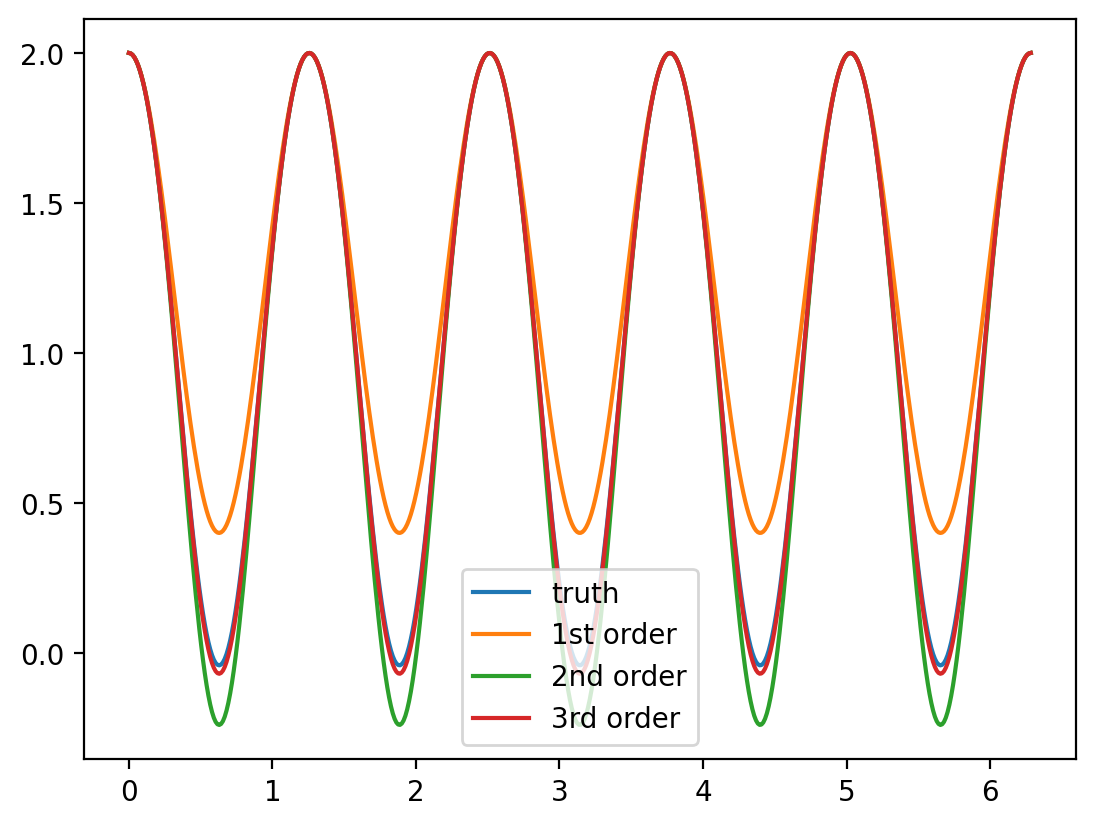

In [27]:
import numpy as np

gamma = 0.05  
def G(z):
    return (1 - np.cos(5*z))*gamma

def g(z):
    return 5*np.sin(5*z)*gamma


def sinSPM(z, y):
    return 1j*g(z)*np.abs(y)**2 * y

def solver(y0, z):
    y = y0
    ans = [y0]
    for i in range(len(z) - 1):
        y = y + (1j) *(G(z[i+1]) - G(z[i]))* np.abs(y)**2 * y
        ans.append(y)
    return np.array(ans)


y0 = 2 + 2j

plt.figure(dpi=200)
z = np.linspace(0, 2*np.pi, 500)
y_truth = y0 * np.exp(1j*G(z)*np.abs(y0)**2)
y1 =  y0 * (1 + 1j*G(z)*np.abs(y0)**2)
y2 = y0 * (1 + 1j*G(z)*np.abs(y0)**2 + (1j*G(z)*np.abs(y0)**2)**2/2)
y3 = y0 * (1 + 1j*G(z)*np.abs(y0)**2 + (1j*G(z)*np.abs(y0)**2)**2/2 + (1j*G(z)*np.abs(y0)**2)**3/6)

plt.plot(z, y_truth.real, label='truth')
plt.plot(z, y1.real, label='1st order')
plt.plot(z, y2.real, label='2nd order')
plt.plot(z, y3.real, label='3rd order')

plt.legend()

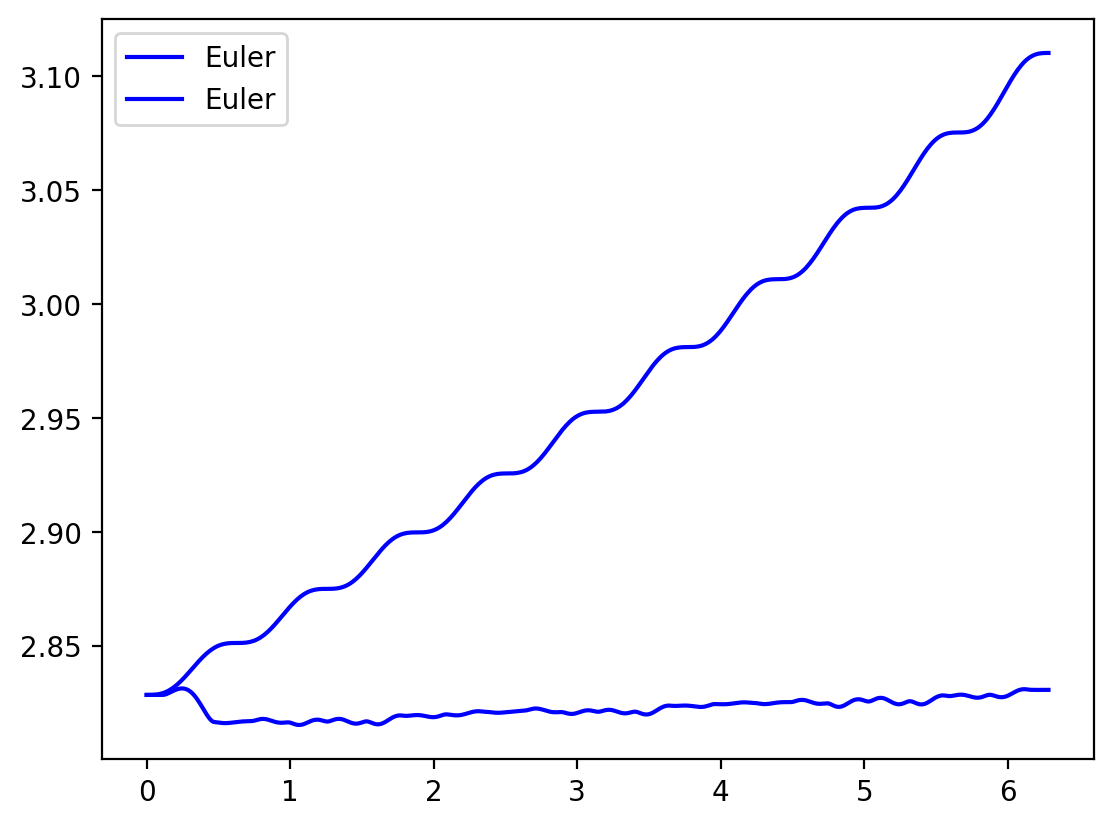

In [28]:
plt.figure(dpi=200)
z = np.linspace(0, 2*np.pi, 200)
y_truth = y0 * np.exp(1j*G(z)*np.abs(y0)**2)
y1 =  y0 * (1 + 1j*G(z)*np.abs(y0)**2)
y2 = y0 * (1 + 1j*G(z)*np.abs(y0)**2 + (1j*G(z)*np.abs(y0)**2)**2/2)


# plt.plot(z, y_truth.real, label='truth')
# plt.plot(z, y1.real, label='1st order')
# plt.plot(z, y2.real, label='2nd order')
z = np.linspace(0, 2*np.pi, 500)
# ans = solver(y0, z)
from scipy.integrate import solve_ivp
sol = solve_ivp(sinSPM, (0, 2*np.pi), np.array([y0]), dense_output=True)
ans = sol.sol(z)
plt.plot(z, np.abs(ans[0]),color='b', label='Euler')

ans = solver(y0, z)
plt.plot(z, np.abs(ans),color='b', label='Euler')

plt.legend()

Learn a solution maping:
$$
y_0   \rightarrow y_0 \exp(ik|y_0|^2)
$$

$$
k = 0.8
$$

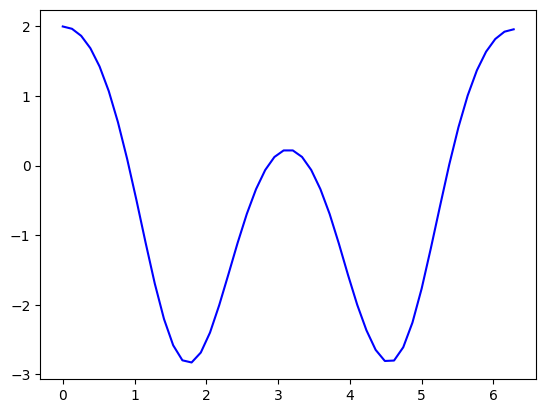

In [7]:
z = np.linspace(0, 2*np.pi, 50)
sol = solve_ivp(sinSPM, (0, 2*np.pi), np.array([y0]), dense_output=True)
ans = sol.sol(z)

plt.plot(z, ans[0].real, color='b', label='Euler')

In [78]:
import torch, torch.nn as nn, matplotlib.pyplot as plt
from src.TorchDSP.layers import ComplexLinear

#  create dataset 

def create(N):
    x = torch.randn(N, 1, dtype=torch.cfloat)
    y = x * torch.exp(1.6j  * torch.abs(x)**2)
    return x, y

torch.manual_seed(1221)
xtrain, ytrain = create(4000)
xtest, ytest = create(4000)

class PBC(nn.Module):

    def __init__(self, steps=2):
        super(PBC, self).__init__()

        self.fc_list = nn.ModuleList([ComplexLinear(1,1, bias=False) for i in range(steps)])
        # self.fc_list = nn.ModuleList([nn.Linear(1,1) for i in range(steps)])

        for fc in self.fc_list:
            nn.init.zeros_(fc.real.weight) # type: ignore
            nn.init.zeros_(fc.imag.weight) # type: ignore

    def forward(self, x):
        # x: [N, 1]
        L = 0
        for fc in self.fc_list:
            x1 = x + fc(torch.abs(x)**2 * x)
            L = L + torch.sum(torch.abs(x1) - torch.abs(x))**2
            x = x1
        return x, L

In [79]:
def train(steps):
    pbc = PBC(steps=steps)
    # optimize pbc use adam with scheduler
    optimizer = torch.optim.Adam(pbc.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1)
    criterion = lambda x,y: torch.log(torch.mean(torch.abs(x-y)**2))

    trl = []
    tel = []

    lamb = 0
    for epoch in range(2000):
        ypred, L = pbc(xtrain)
        loss = criterion(ypred, ytrain) + lamb*L
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 10 == 0:
            ypred, _ = pbc(xtest)
            test_loss= criterion(ypred, ytest)
            trl.append(loss.item())
            tel.append(test_loss.item())

            if epoch % 100 == 0:
                print(f'epoch {epoch}, train loss {loss.item()}, test loss {test_loss.item()}')

    return trl, tel

In [80]:
a1, b1 = train(1)
a2, b2 = train(2)
a3, b3 = train(3)

epoch 0, train loss 0.8041481375694275, test loss 0.8030549883842468
epoch 100, train loss 0.6134706735610962, test loss 0.608073353767395
epoch 200, train loss 0.46306532621383667, test loss 0.45661264657974243
epoch 300, train loss 0.36898353695869446, test loss 0.3650699853897095
epoch 400, train loss 0.3242521286010742, test loss 0.3247048258781433
epoch 500, train loss 0.3216836452484131, test loss 0.32252517342567444
epoch 600, train loss 0.31918561458587646, test loss 0.3204428553581238
epoch 700, train loss 0.3168119788169861, test loss 0.31850704550743103
epoch 800, train loss 0.3146073818206787, test loss 0.3167702853679657
epoch 900, train loss 0.31439220905303955, test loss 0.3166019916534424
epoch 1000, train loss 0.31416699290275574, test loss 0.316426157951355
epoch 1100, train loss 0.3139325678348541, test loss 0.31624388694763184
epoch 1200, train loss 0.31369006633758545, test loss 0.3160580098628998
epoch 1300, train loss 0.313664972782135, test loss 0.31603863835334

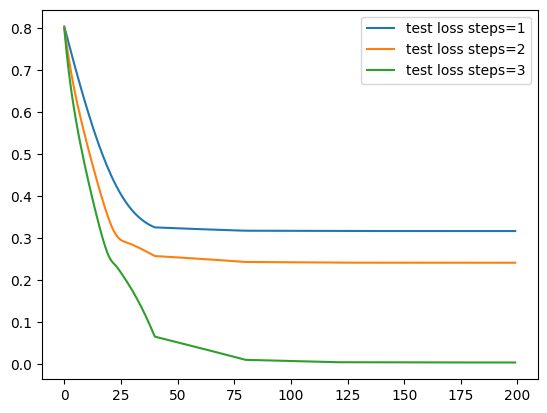

In [81]:
plt.plot(b1, label='test loss steps=1')
plt.plot(b2, label='test loss steps=2')
plt.plot(b3, label='test loss steps=3')
plt.legend()

# Example equation 2:
$$
a_p(z)' = -i\gamma \sum_{m,n} X_{m,n}(z) a_{p+m}(z) a_{p+n}(z) a_{p+m+n}^*(z)
$$

$$
X_{m,n}(z) = \frac{f(z) \exp(\frac{imn}{z})}{z} \max\{1-\frac{|m|+|n|}{2\pi z}, 0\}, m\neq 0 \ and \ n \neq 0
$$

$$
X_{0,0}(z) = \frac{f(z)}{z}
$$

$$
f(z) = \exp(-z \mod 1)
$$


In [76]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

gamma = 0.1
def f(z):
    return np.exp(z % 1)

def X(z,m,n):
    if m==0 and n == 0:
        return f(z)/z
    else:
        return f(z)*np.exp(1j*m*n/z)/z * np.max(1-(np.abs(m)+np.abs(n))/(2*np.pi*z), 0)


def RHS(z, a):
    k = len(a)//2
    b = np.zeros_like(a)
    for m in range(-k, k+1):
        for n in range(-k, k+1):
            b = b + X(z, m, n) * np.roll(a, m) * np.roll(a, n) * np.roll(a, m+n).conj()
    return -1j*gamma*b


In [102]:
np.random.randn(10,2)

array([[ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071],
       [-0.3224172 , -0.38405435],
       [ 1.13376944, -1.09989127],
       [-0.17242821, -0.87785842],
       [ 0.04221375,  0.58281521],
       [-1.10061918,  1.14472371],
       [ 0.90159072,  0.50249434],
       [ 0.90085595, -0.68372786]])

In [104]:
ndim = 3
np.random.seed(1)
a = np.random.randn(ndim) + np.random.randn(ndim) * (1j)

t_span = (0.01, 1)
sol = solve_ivp(RHS, t_span, a, dense_output=True, rtol=1e-5, atol=1e-8, method='DOP853')
t = np.linspace(t_span[0], t_span[1], 400)
y = sol.sol(t)

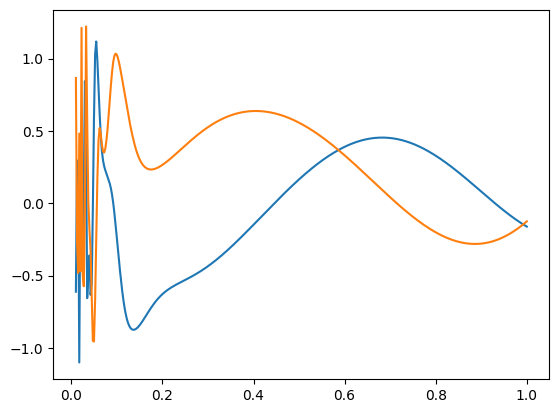

In [100]:
plt.plot(t, y[1].real)
plt.plot(t, y[1].imag)

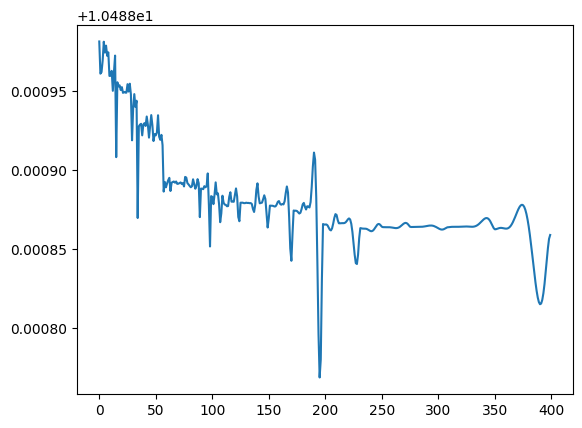

In [95]:
plt.plot(np.sum(np.abs(y)**2, axis=0))

# Equation 1: SPM 

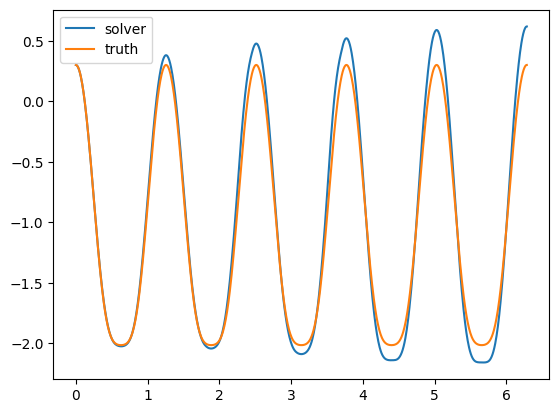

In [12]:
from scipy.integrate import solve_ivp
import numpy as np, matplotlib.pyplot as plt

def g(z):
    return 5*np.sin(5*z) * 0.2

def G(z):
    return (1 - np.cos(5*z)) * 0.2


# 定义复数ODE
def complex_ode(z, y):
    return 1j * g(z) * np.abs(y)**2 * y

# 复数初始条件
y0_complex = 0.3 + 2j  # u(0) = 1, v(0) = 0

# 使用solve_ivp求解复数ODE
z0, z_max = 0, 2*np.pi
z = np.linspace(z0, z_max, 1000)

sol_true = y0_complex*np.exp(1j*G(z)*np.abs(y0_complex)**2)
sol_complex = solve_ivp(complex_ode, [z0, z_max], [y0_complex], t_eval=z, method='RK45')

# 检查解的类型以确认它是复数
plt.plot(z, sol_complex.y[0].real, label='solver')
plt.plot(z, sol_true.real, label='truth')
plt.legend()

function times :290


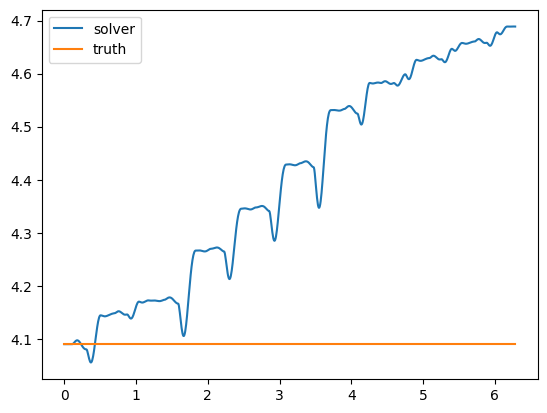

In [13]:
print(f'function times :{sol_complex.nfev}')
# 检查解的类型以确认它是复数
plt.plot(z, np.abs(sol_complex.y[0])**2, label='solver')
plt.plot(z, np.abs(sol_true)**2, label='truth')
plt.legend()
